In [19]:
import pandas as pd
import numpy as np
import obonet
import networkx as nx

# Load the data generated from the R code

In [56]:
bp_db = pd.read_csv("../data/annotations-gene-GO.csv")
bp_db = bp_db.drop_duplicates()
bp_db.head()

,ENSEMBL,GO
0,ENSG00000000003,GO:0039532
1,ENSG00000000003,GO:0043123
2,ENSG00000000003,GO:1901223
3,ENSG00000000005,GO:0001886
4,ENSG00000000005,GO:0001937


In [55]:
bp_db.describe()

,ENSEMBL,GO
count,132627,132627
unique,17599,12305
top,ENSG00000148400,GO:0006357
freq,158,1426


In [21]:
counts1 = pd.read_csv("../data/counts1.csv", index_col=0)
counts1.head()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSGR0000167393,ENSGR0000169084,ENSGR0000169093,ENSGR0000178605,ENSGR0000182378,ENSGR0000185291,ENSGR0000198223,ENSGR0000214717,ENSGR0000223511,ENSGR0000223773
089357B,14,7,103,241,72,2057,30,60,207,367,...,1,0,0,0,0,0,0,0,0,0
089366A,11,2,194,511,110,3325,36,111,186,530,...,0,0,0,0,0,0,1,0,0,1
089412B,8,0,312,450,106,3751,45,160,325,653,...,0,0,0,0,0,0,1,0,0,0
089425B,9,0,135,496,133,2758,26,93,182,620,...,0,0,0,0,0,0,0,0,0,0
089687A,4,0,89,267,49,2181,24,75,122,263,...,0,0,0,0,0,0,1,0,0,0


In [22]:
pheno1 = pd.read_csv("../data/pheno1.csv", index_col=0)
pheno1.head()

,age,diagnosis,sex,lithium,condition
089357B,18,Control,F,0,Control
089366A,19,Control,F,0,Control
089412B,23,Control,F,0,Control
089425B,47,Control,F,0,Control
089687A,52,Control,F,0,Control


# Data Exploration Analysis

In [48]:
available_genes = set(bp_db.ENSEMBL)
("length of all_genes :", len(available_genes))

('length of all_genes :', 17600)

In [36]:
data_genes = set(counts1.columns)
("length of data_genes :", len(data_genes))

('length of data_genes :', 52645)

In [37]:
("Number of genes missing :", len(data_genes - available_genes))

('Number of genes missing :', 35046)

In [38]:
("Ratio of genes missing : {:.2f}%".format(len(data_genes - available_genes) / len(data_genes) * 100))

'Ratio of genes missing : 66.57%'

## load GO graph

In [39]:
# Read the gene ontology
!wget http://purl.obolibrary.org/obo/go/go-basic.obo 
original_graph = obonet.read_obo('go-basic.obo')
!rm go-basic.obo

--2024-04-19 00:46:35--  http://purl.obolibrary.org/obo/go/go-basic.obo
Resolving purl.obolibrary.org (purl.obolibrary.org)... 2606:4700:4400::6812:253b, 2606:4700:4400::ac40:96c5, 172.64.150.197, ...
Connecting to purl.obolibrary.org (purl.obolibrary.org)|2606:4700:4400::6812:253b|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://current.geneontology.org/ontology/go-basic.obo [following]
--2024-04-19 00:46:37--  http://current.geneontology.org/ontology/go-basic.obo
Resolving current.geneontology.org (current.geneontology.org)... 2600:9000:24db:1a00:d:ff6c:c780:93a1, 2600:9000:24db:6600:d:ff6c:c780:93a1, 2600:9000:24db:c600:d:ff6c:c780:93a1, ...
Connecting to current.geneontology.org (current.geneontology.org)|2600:9000:24db:1a00:d:ff6c:c780:93a1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31267219 (30M) [text/obo]
Saving to: ‘go-basic.obo’

go-basic.obo        100%[===================>]  29.82M  10.6MB/s    in 2.8s    

2

## only keep the Biological Process (BP) subgraph

In [40]:
bp_node = "GO:0008150"
bp_graph_nodes = nx.ancestors(original_graph, bp_node)
bp_graph_nodes.add(bp_node)
bp_graph = original_graph.subgraph(bp_graph_nodes)
print("Number of nodes in the graph", len(bp_graph_nodes))

Number of nodes in the graph 27074


## remove the subgraph which are not in the list of GO terms

In [49]:
bp_db_nodes = set(bp_db.GO.unique())
len(bp_db_nodes)

12306

iterate from the leaves to the root, trim all the branches that do not contain any db GO term

In [42]:
from tqdm import tqdm

leaves = [x for x in bp_graph_nodes if bp_graph.in_degree(x) == 0 and x not in bp_db_nodes]
removes, keeps = set(), set()

for child in tqdm(leaves):
    ancestors = nx.descendants(bp_graph, child)
    for ancestor in ancestors:
        if ancestor not in removes and ancestor not in keeps:
            if ancestor not in bp_db_nodes:
                descendants = set(nx.ancestors(bp_graph, ancestor))
                if len(descendants.intersection(bp_db_nodes)) == 0:
                    removes.add(ancestor)
                else:
                    keeps.add(ancestor)
            else:
                keeps.add(ancestor)

100%|██████████| 7255/7255 [01:47<00:00, 67.62it/s] 


In [43]:
removes = removes.union(set(leaves))
len(removes)

11707

In [44]:
bp_graph_nodes = bp_graph_nodes - removes
bp_graph = bp_graph.subgraph(bp_graph_nodes)
print("Number of nodes in the graph", len(bp_graph_nodes))

Number of nodes in the graph 15367


In [45]:
# import pickle
# 
# with open('gobp-entire.gpickle', 'wb') as f:
#     pickle.dump(graph_BP, f, pickle.HIGHEST_PROTOCOL)

## filtered go term table

In [78]:
bp_db_filter = bp_db[bp_db.GO.isin(bp_graph.nodes) & bp_db.ENSEMBL.isin(data_genes)]
bp_db_filter.describe()

,ENSEMBL,GO
count,131837,131837
unique,17589,12114
top,ENSG00000148400,GO:0006357
freq,158,1426


In [58]:
gp = bp_db_filter.groupby("ENSEMBL")
for ensembl in tqdm(list(gp.groups.keys())):
    go_associated = gp.get_group(ensembl)["GO"].tolist()
    indexes = list(gp.groups[ensembl])
    current_idx = 0
    while current_idx < len(go_associated):
        go_visited = go_associated[current_idx]
        idx = indexes.pop(0)
        successors = set(nx.ancestors(bp_graph, go_visited))
        if len(successors.intersection(set(go_associated))) != 0:
            file_go = bp_db_filter.drop(idx)
            keep1 = go_visited
            keep2 = idx
        current_idx += 1

100%|██████████| 17589/17589 [06:31<00:00, 44.95it/s] 


In [ ]:
bp_db_filter.describe()

In [79]:
bp_db_filter.to_csv("../data/GOannotations_kept.csv")

## GO graph statistics 

In [84]:
def compute_level(node):
    if node != bp_node:
        return len(max(nx.all_simple_paths(bp_graph, node, bp_node), key=lambda x: len(x))) - 1
    else:
        return 0

In [88]:
in_d = [x[1] for x in bp_graph.in_degree()]
out_d = [x[1] for x in bp_graph.out_degree()]
levels = [compute_level(node) for node in bp_graph.nodes]
go_nodes = list(bp_graph.nodes)
dfInfoGraph = pd.DataFrame({"root": levels, "d+": out_d, "d-": in_d}, index=go_nodes)
dfInfoGraph.head()

,root,d+,d-
GO:0032011,8,1,2
GO:0090084,7,3,2
GO:1903279,11,2,2
GO:0030638,3,2,2
GO:0000966,8,1,4


In [89]:
dfInfoGraph.describe()

,root,d+,d-
count,15367.000000,15367.000000,15367.000000
mean,7.980217,2.253986,2.253986
std,2.595890,1.019135,4.229011
min,0.000000,0.000000,0.000000
25%,6.000000,2.000000,0.000000
50%,8.000000,2.000000,1.000000
75%,10.000000,3.000000,3.000000
max,18.000000,9.000000,136.000000


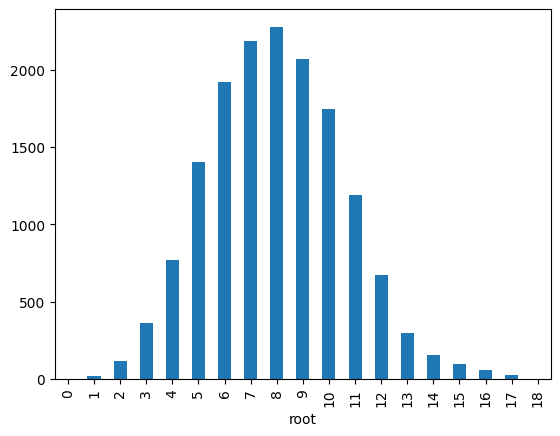

In [92]:
import matplotlib.pyplot as plt

dfInfoGraph.groupby("root").size().plot(kind='bar')
plt.show()

In [93]:
dfInfoGraph.to_csv("../data/go_to_level_entire.csv")

## GO 

In [ ]:
map_go_int={go:idx for idx,go in enumerate(list_go)}
map_go_int